## Classification of Income Being Above or Below/Equal to $50,000 in Adult Census Data

By: Sunsar, Sarah, Emily, Calvin (DSCI 100 003 - Group 23)

Data is from: https://www.kaggle.com/datasets/uciml/adult-census-income

The dataset used for this analysis is derived from the 1994 Census Bureau database. 

The dataset contains a diverse range of numerical and categorical attributes, such as age, hours worked per week,  sex, and more. In this project, we will filter and simplify some categories from this dataset to predict whether an individual"s annual salary falls above or below/equal to $50,000.

The question this project will seek to answer is: 

**How do different aspects of a person predict whether annual income will be above or below/equal to $50K annually?**

# Reading in Data

In [33]:
library(tidyverse)
library(tidymodels)

In [34]:
set.seed(123)

df = read_csv("https://raw.githubusercontent.com/calvingdu/dsci100-003-23/master/data/adult_census.csv")

# Splitting the data
df_split <- initial_split(df, prop = 0.8, strata = income)
df_train <- training(df_split)
df_test <- testing(df_split)

paste0("Training set row count: ", nrow(df_train))
paste0("Testing set row count: ", nrow(df_test))

Rows: 32561 Columns: 15
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (9): workclass, education, marital.status, occupation, relationship, rac...
dbl (6): age, fnlwgt, education.num, capital.gain, capital.loss, hours.per.week

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Training set row count: 26048"

[1] "Testing set row count: 6513"

In [35]:
head(df_train, 3)

age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K


# Tidying/Cleaning The Data & Selecting Columns
We can begin by tidying up the data. Something we noticed immediately that there are a lot of categorical columns. To tackle this, we plan to make buckets of categories and then turn them into dummy variables. For example, we can turn __sex__ into a dummy variable where 0 = male and 1 = female, make dummy variables by bucketting different things such as paid/unpaid in __workclass__, or making a dummy variable for every unique value. 

These are the columns we plan to use and how we plan to tackle them to make them usable in data: 
- **Age**: No changes (either than scaling/imputation)
- **Education**: Simplified to a dummy variable of if College Graduate or Not
- **Occupation**: Make a dummy variable for all the occupations
- **Sex**: Transformed into a Dummy Variable
- **Capital Gain**: No changes (either than scaling/imputation)
- **Capital Loss**: No changes (either than scaling/imputation)
- **Hours Per Week**: No changes (either than scaling/imputation)
- **Native Country**: Evaluated what country has the most people with income > 50k (United States by a large margin) and then make a dummy variable for being in this country or not 

**Dropped Columns & Reasoning**: 
- fnlwgt: Unclear how this relates
- education.num: Already have education
- Workclass: Don"t believe this is significant to the study so removing to avoid overfitting 
- race: Don"t believe this is significant to the study so removing to avoid overfitting 
- marital.status: Don"t believe this is significant to the study so removing to avoid overfitting
- Relationship: Don"t believe this is significant to the study so removing to avoid overfitting


This is also some tidying to do. We can initially see that there are some missing values in __workclass__ and __occupation__ represented as ?. Since we believe these are extremely important roles to guess income category, we remove any rows that don't have data for this. 

In [110]:
filtered_df <- df_train |>
  select(age, education, occupation, sex,
         capital.gain, capital.loss, hours.per.week, native.country, income) |>
  filter(occupation != "?")

Then, we can begin by making dummy variables in the data using the above choices

### Binary Preprocessing

In [111]:
# Making a function to be used later
preprocess_binary <- function(df){
    transformed_df <- df |>
        mutate(college_grad = ifelse(education == 'Some-college'| education =='Masters'| education =='Bachelors' | education == "Prof-school",1,0)) |>
        mutate(sex_dummy = ifelse(sex == "Female", 1, 0)) |>
        mutate(is_american = ifelse(native.country == "United-States", 1, 0))
        #mutate(being_paid = ifelse(workclass != "Self-emp-not-inc" & workclass != "Without-pay" & workclass != "Never-worked", 1, 0)) |>
        #mutate(is_married = ifelse((relationship == "Husband" | relationship == "Wife" |relationship == "Wife"),1,0))
    return(transformed_df)
}

binary_df <- preprocess_binary(filtered_df)

### Dummy Variables for Every Occupation

In [112]:
unique_occupations <- as.list(unique(binary_df$occupation))

# Making a function to use later
preprocess_occupation <- function(df, occupations){
    for (occ in occupations) {
        col_name <- gsub("[^a-zA-Z0-9 ]", ".", tolower(occ))
        df[[col_name]] <- as.integer(df$occupation == occ)
    }
    return(df)
}

occupations_df <- preprocess_occupation(binary_df, unique_occupations)

### Removing Original Variables

In [113]:
# tidy_df <- occupations_df |>
#     select(-c(occupation, workclass, education, occupation, relationship, native.country))

# head(tidy_df)

tidy_df <- occupations_df

Below is an function that does all of our pre-processing. It can be verified by checking if the changes we made above are the same as the changes made by the function

In [108]:
process_df <- function(df){
    filtered_df <- df |>
    select(age, workclass, education, occupation, relationship, sex,
            capital.gain, capital.loss, hours.per.week, native.country, income) |>
    filter(workclass != "?" & occupation != "?")

    binary_df <- preprocess_binary(filtered_df)

    unique_occupations <- as.list(unique(binary_df$occupation))
    occupations_df <- preprocess_occupation(binary_df, unique_occupations) 
    new_cols_df <- select(occupations_df, -c(occupation, workclass, education, occupation, relationship, sex, native.country))

    return(new_cols_df)
}

processed_df_train <- process_df(df_train)
print(all.equal(processed_df_train, tidy_df) & all.equal(colnames(processed_df_train), colnames(tidy_df)))

ERROR: Error in all.equal(processed_df_train, tidy_df) & all.equal(colnames(processed_df_train), : operations are possible only for numeric, logical or complex types


# Exploratory Data Analysis



## Summary Table

In [122]:
summary_table <- tidy_df |>
group_by(income) |>
summarize(across(everything(), ~ round(mean(., na.rm = TRUE), 2), .names = "mean_{.col}")) 

summary_table

Warning message:
"There were 8 warnings in `summarize()`.
The first warning was:
i In argument: `across(everything(), ~round(mean(., na.rm = TRUE), 2), .names =
  "mean_{.col}")`.
i In group 1: `income = "<=50K"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
i Run `dplyr::last_dplyr_warnings()` to see the 7 remaining warnings."


income,mean_age,mean_education,mean_occupation,mean_sex,mean_capital.gain,mean_capital.loss,mean_hours.per.week,mean_native.country,mean_college_grad,...,mean_sales,mean_transport.moving,mean_craft.repair,mean_other.service,mean_farming.fishing,mean_protective.serv,mean_tech.support,mean_handlers.cleaners,mean_priv.house.serv,mean_armed.forces
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<=50K,36.54,NA,NA,NA,143.81,53.95,39.39,NA,0.40,...,0.12,0.05,0.14,0.13,0.04,0.02,0.03,0.06,0.01,0
>50K,43.92,NA,NA,NA,4094.82,196.29,45.76,NA,0.64,...,0.13,0.04,0.12,0.02,0.01,0.03,0.04,0.01,0.00,0


In [143]:
descending_df <- tidy_df %>%
  filter(income == "<=50K") %>% 
  group_by(native.country) %>%
  summarize(rich = n()) %>%
  ungroup() %>%
  mutate(total_count = sum(rich)) %>%
  mutate(rich_proportion = rich / total_count) %>%
  arrange(desc(rich_proportion))

head(descending_df)

native.country,rich,total_count,rich_proportion
<chr>,<int>,<int>,<dbl>
United-States,16427,18460,0.889869989
Mexico,454,18460,0.024593716
?,320,18460,0.017334778
Philippines,103,18460,0.005579632
Puerto-Rico,84,18460,0.004550379
El-Salvador,77,18460,0.004171181


In [145]:
tidy_df %>% 
group_by(is_american, college_grad) %>% 
summarize(proportion = (sum(income == ">50K") / n()) * 100) %>%
mutate(american_label = ifelse(is_american == 1, "American", "Non-American")) %>%
mutate(college_grad_label = ifelse(college_grad == 1, "College Graduate", "Not College Grad")) %>%
ggplot(aes(x ))

`summarise()` has grouped output by 'is_american'. You can override using the
`.groups` argument.


is_american,college_grad,proportion,american_label,college_grad_label
<dbl>,<dbl>,<dbl>,<chr>,<chr>
0,0,12.28188,Non-American,Not College Grad
0,1,31.18483,Non-American,College Graduate
1,0,17.26637,American,Not College Grad
1,1,34.74379,American,College Graduate


This table shows the mean value for every column in each category split by the income category

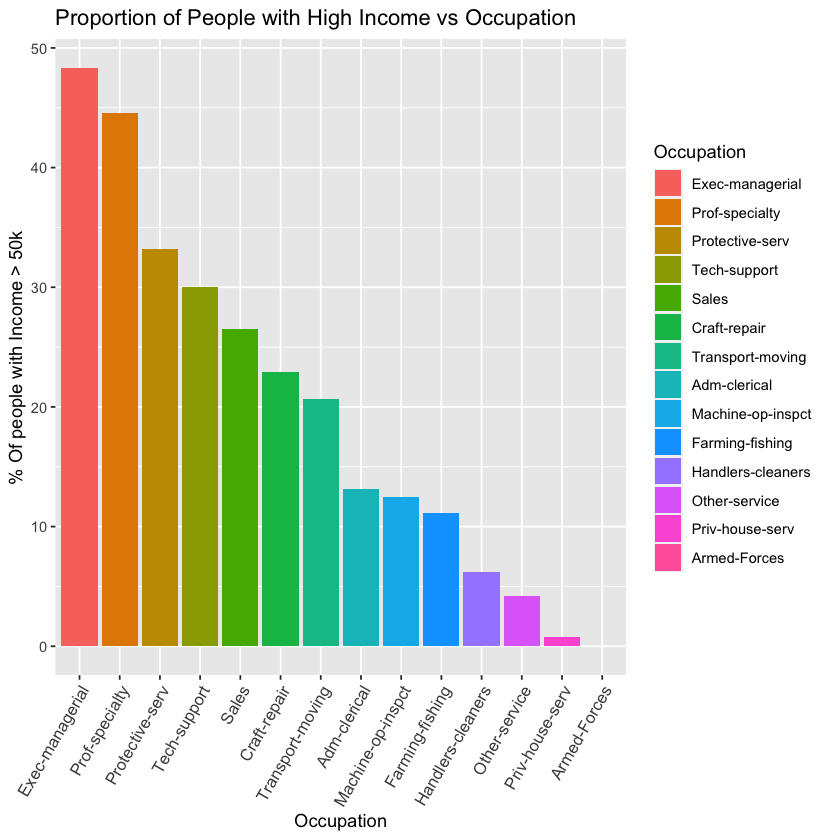

In [80]:
tidy_df %>% 
group_by(occupation) %>% 
summarize(proportion = (sum(income == ">50K") / n()) * 100) %>% 
ggplot(aes(x = reorder(occupation, -proportion), y = proportion, fill = reorder(occupation, -proportion))) + 
geom_bar(stat = "identity") + 
labs(x = "Occupation", y = "% Of people with Income > 50k", title = "Proportion of People with High Income vs Occupation", fill = "Occupation") + 
theme(axis.text.x = element_text(size = 10, angle = 60, hjust = 1))

Clearly executive managerial has the highest proportion of people with greatest income

# Citation 1: 
*"There are sizeable earnings differentials by both gender and race in the U.S. labor market, with women earning less than men"* (Greenman & Xie, 2008)

This article claims that there's a pattern between sex in income class. We can explore our dataset to see how this compares to this claim

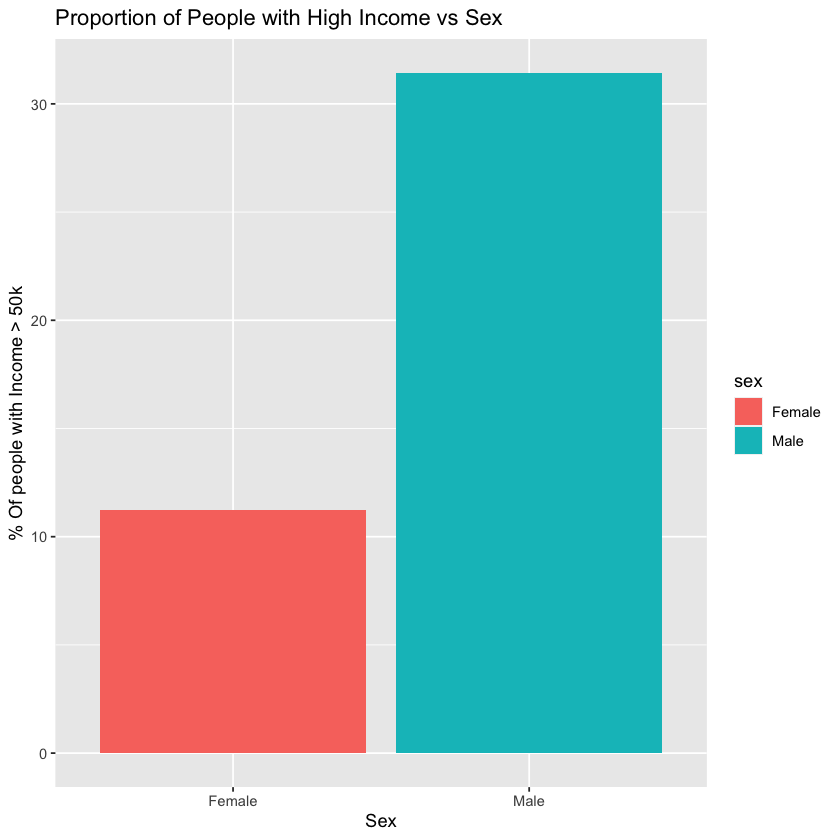

In [81]:
sex_plot <- tidy_df %>% 
    group_by(sex) %>% 
    summarize(proportion = (sum(income == ">50K") / n()) * 100) %>% 
    ggplot(aes(x = sex, y = proportion, fill = sex)) + 
    geom_bar(stat = "identity") + 
    labs(x = "Sex", y = "% Of people with Income > 50k", title = "Proportion of People with High Income vs Sex")

sex_plot


This matches up 

# Citation 2. 

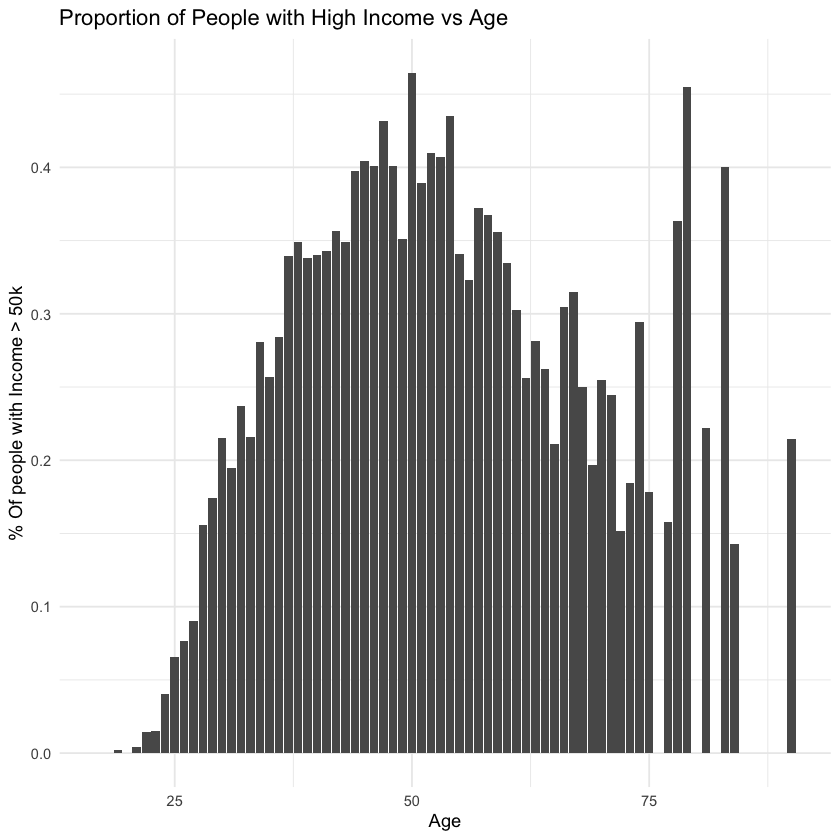

In [82]:
age_plot <- tidy_df %>%
  group_by(age) %>%
  summarise(proportion = sum(income == ">50K") / n()) |>
    ggplot(aes(x = age, y = proportion)) +
    geom_bar(stat = "identity") +
    labs(x = "Age", y = "% Of people with Income > 50k") +
    ggtitle("Proportion of People with High Income vs Age") + 
    theme_minimal()
  
  age_plot

Shows what we expect where people who have income >50K will peak at their 50s. 

We can see outliers in the older ages (about 80) and can investigate why this is.

In [83]:
tidy_df %>% 
filter(age > 75) %>% 
filter (income == ">50K") %>% 
select(age, occupation) %>% 
group_by(occupation) %>% 
summarize (count_occ = n()) %>% 
arrange(-count_occ)

occupation,count_occ
<chr>,<int>
Exec-managerial,8
Sales,7
Prof-specialty,3
Craft-repair,2
Farming-fishing,2
Adm-clerical,1


We can see that most of the people with income > 50k after the age of 75 are executive managers or in sales which can explain the outliers 

---

Plots to be made (Shows more trends) 
- Age (X = age, y = income )
- 

Analysis To be done: 
- 


## References Cited
- Greenman, E., & Xie, Y. (2008). Double Jeopardy? The Interaction of Gender and Race on Earnings in the U.S. Social forces; a scientific medium of social study and interpretation, 86(3), 1217–1244. https://doi.org/10.1353/sof.0.0008